# 1. Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import random
import pickle

# 2. Loading Data

In [2]:
# Loading the match and delivery datasets
match = pd.read_csv('data/matches.csv')
delivery = pd.read_csv('data/deliveries.csv')

# 3. Data Preprocessing

## 3.1 Calculating Total Score for the First Innings

In [3]:
# Grouping and calculating total score for the first innings
total_score_df = delivery.groupby(['match_id', 'inning'])['total_runs'].sum(numeric_only=True).reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1].rename(columns={'total_runs': 'inning1_runs'})

# Merging match data with total scores
match_df = match.merge(total_score_df[['match_id', 'inning1_runs']], left_on='id', right_on='match_id')

## 3.2 Handling City Name and Team Names Changes

In [4]:
# Drop empty city names and replace old city names with new ones
match_df = match_df.dropna(subset=['city'])
match_df['city'] = match_df['city'].str.replace('Bangalore','Bengaluru')

# Replacing old team names with new ones
team_replacements = {
    'Kings XI Punjab': 'Punjab Kings',
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad'
}
for old_name, new_name in team_replacements.items():
    match_df['team1'] = match_df['team1'].str.replace(old_name, new_name)
    match_df['team2'] = match_df['team2'].str.replace(old_name, new_name)
    match_df['winner'] = match_df['winner'].str.replace(old_name, new_name)

# Filtering for relevant teams
teams = [
    'Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bengaluru', 'Kolkata Knight Riders',
    'Punjab Kings', 'Chennai Super Kings', 'Rajasthan Royals', 'Delhi Capitals',
    'Gujarat Titans', 'Lucknow Super Giants'
]
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

# Preparing final match data frame and Drop rows where the 'winner' column is NaN
match_df = match_df[['match_id','city','winner','inning1_runs']].dropna(subset=['winner'])

## 3.3 Preparing the Delivery Data for the Second Innings

In [5]:
# Merging and filtering delivery data for the second innings
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

# Replacing old team names in the delivery data
for old_name, new_name in team_replacements.items():
    delivery_df['batting_team'] = delivery_df['batting_team'].str.replace(old_name, new_name)
    delivery_df['bowling_team'] = delivery_df['bowling_team'].str.replace(old_name, new_name)

## 3.4 Feature Engineering

In [6]:
# Calculating current score, runs left and balls left
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs'].cumsum(numeric_only=True)
delivery_df['runs_left'] = delivery_df['inning1_runs'] + 1 - delivery_df['current_score']
delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'])

# Handling player dismissals and calculating wickets left
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0").apply(lambda x: '1' if x != "0" else '0').astype(int)
delivery_df['wickets_left'] = 10 - delivery_df.groupby('match_id')['player_dismissed'].cumsum()

# Calculating Current Run Rate (CRR) and Required Run Rate (RRR)
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

## 3.5 Label Creation

In [7]:
# Defining the result of the match: 1 if batting team wins, 0 otherwise
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

delivery_df['result'] = delivery_df.apply(result, axis=1)

# 4. Model Creation

## 4.1 Data Preparation for the Model

In [8]:
# Preparing final dataset for training
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'inning1_runs', 'crr', 'rrr', 'result']].dropna()
final_df = final_df[final_df['balls_left'] != 0]
final_df = final_df.sample(final_df.shape[0])
# print(final_df.isnull().sum())

# Splitting the data into features (X) and target (y)
X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 4.2 Model Pipeline

In [9]:
# Creating a column transformer for categorical variables
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False, drop='first'), ['batting_team', 'bowling_team', 'city'])
], remainder='passthrough')

# Defining the pipeline with a logistic regression model
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
    # ('step2',RandomForestClassifier())
])

# Training the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

# 5. Model Evaluation

In [10]:
# Predicting results for the test set
y_pred = pipe.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
random_index = random.randint(0, len(X_test) - 1)
print(pipe.predict_proba(X_test)[random_index])

Accuracy: 0.806203007518797
[0.04755842 0.95244158]


# 6. Match Prediction and Progression

## 6.1 Match Progression Function

In [11]:
# Function to display match progression over time
def match_progression(x_df, match_id, pipe):
    # Filter the match data for the specified match and overs only
    match = x_df[x_df['match_id'] == match_id] 
    # Get max ball for each over
    max_ball_df = match.groupby('over')['ball'].max().reset_index()
    match = match.merge(max_ball_df, on=['over', 'ball'], how='inner')
    
    # Select relevant columns and filter invalid data
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'inning1_runs', 'crr', 'rrr']].dropna()
    # Ensure we exclude cases with 0 balls left
    temp_df = temp_df[temp_df['balls_left'] != 0]

    # Predict probabilities
    result = pipe.predict_proba(temp_df)

    # Adding lose and win probabilities
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)

    # Add a progression over each over
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    # Calculate runs scored after each over
    target = temp_df['inning1_runs'].values[0] + 1
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)

    # Calculate wickets lost each over
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    # Return relevant columns
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target

## 6.2 Visualization of Match Progression

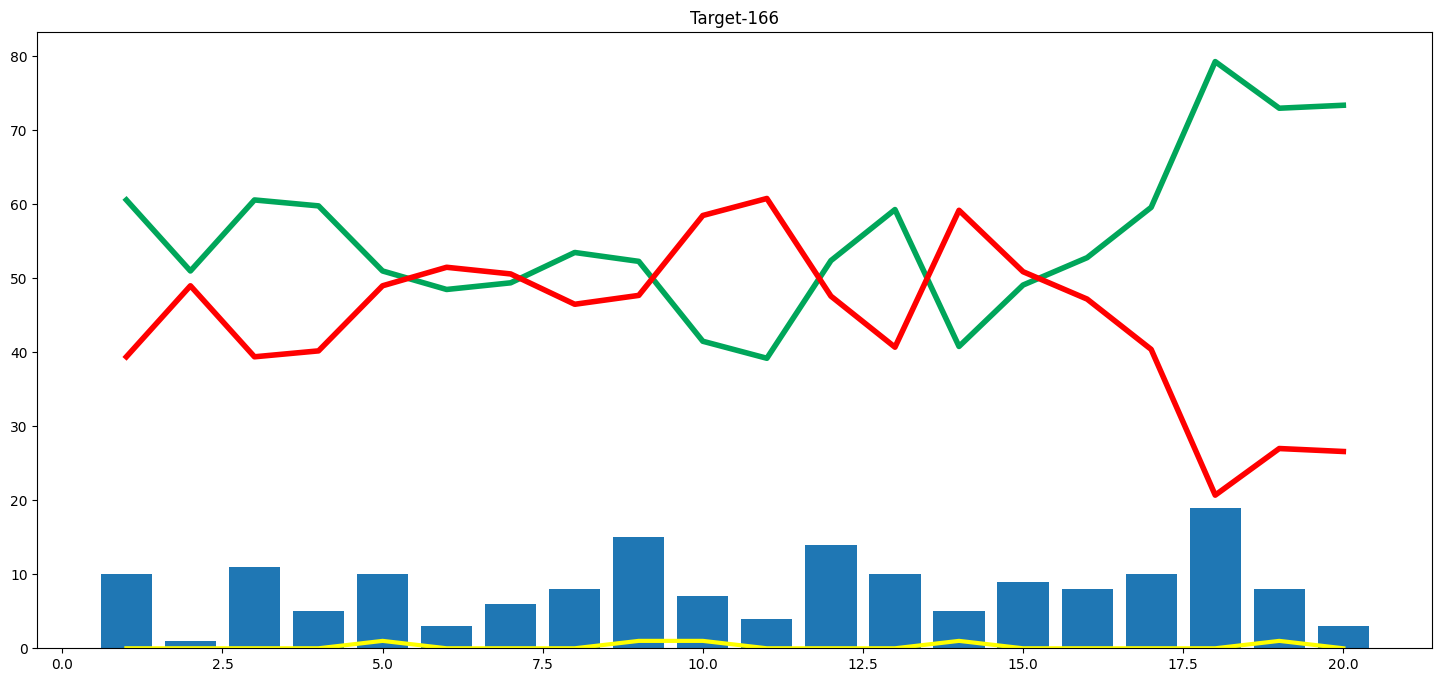

In [12]:
# Visualizing match progression
temp_df, target = match_progression(delivery_df, 335985, pipe)

plt.figure(figsize=(18, 8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3)
plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4)
plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4)
plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'])
plt.title('Target-' + str(target))
plt.show()

# 7. Saving the Model

In [13]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))